In [ ]:
import kagglehub
from tensorflow.keras.applications import Xception

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
import glob
import os
from tensorflow.keras.models import load_model

In [ ]:
path = kagglehub.dataset_download("atrithakar/banana-classification")

print("Path to dataset files:", path)

100%|██████████| 218M/218M [00:02<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/atrithakar/banana-classification/versions/1


In [ ]:
BATCH_SIZE = 32
path = path+"/banana_classification"

##Função para aumentar e carregar os dados

In [ ]:
def load_data(img_size):
  train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True
  )

  val_datagen = ImageDataGenerator(rescale=1.0/255)

  test_datagen = ImageDataGenerator(rescale=1.0/255)

  test_generator = test_datagen.flow_from_directory(
      path + '/test',
      target_size=img_size,
      batch_size=1,
      color_mode='rgb',
      class_mode="categorical",
      shuffle=False
  )

  train_generator = train_datagen.flow_from_directory(
      path + '/train',
      target_size=img_size,
      batch_size=BATCH_SIZE,
      color_mode='rgb',
      class_mode="categorical"
  )

  val_generator = val_datagen.flow_from_directory(
      path + '/valid',
      target_size=img_size,
      batch_size=BATCH_SIZE,
      color_mode='rgb',
      class_mode="categorical"
  )
  return train_generator, val_generator, test_generator

##Função para montar o modelo, que recebe as camada finais personalizadas e o modelo base como parametro

In [ ]:
def create_transfer_learning_model(base_model, x):
    base_model.trainable = False

    output_layer = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


##Função para plotar o histórico de treinamento

In [ ]:
def plot_training_history(history):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
  plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
  plt.title('Acurácia durante o Treinamento')
  plt.xlabel('Épocas')
  plt.ylabel('Acurácia')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Erro de Treinamento')
  plt.plot(history.history['val_loss'], label='Erro de Validação')
  plt.title('Erro durante o Treinamento')
  plt.xlabel('Épocas')
  plt.ylabel('Perda (Loss)')
  plt.legend()

  plt.tight_layout()
  plt.show()

##Função para testar e plotar a matriz de confusão

In [ ]:
def plot_confusion_matrix(model, test_generator, nome):
  predictions = model.predict(test_generator, verbose=1)

  predicted_classes = np.argmax(predictions, axis=1)

  true_classes = test_generator.classes

  cm = confusion_matrix(true_classes, predicted_classes)

  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  class_names = list(test_generator.class_indices.keys())

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.title(f'Matriz de Confusão {nome}')
  plt.xlabel('Classe Predita')
  plt.ylabel('Classe Real')
  plt.show()


##Funcão para treinar o modelo

In [ ]:
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint

def train_model(model, train_generator, val_generator, epochs=30, name="best_model.keras"):
    checkpoint = ModelCheckpoint(
        f'/content/drive/MyDrive/banana-results/{name}_best_weights.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[checkpoint]
    )

    with open(f'/content/drive/MyDrive/banana-results/{name}_history.pkl', 'wb') as history_file:
        pickle.dump(history.history, history_file)

    model.save(f'/content/drive/MyDrive/banana-results/{name}_final_weights.keras')

    return history


##Funcão para buscar os modelos salvos e submeter-los aos testes

In [ ]:
def test_model(name, folder_path='/content/drive/MyDrive/banana-results/', generator):

    model_files = glob.glob(f'{folder_path}{name}*.keras')

    for model_file in model_files:
        print(f"Carregando modelo: {model_file}")

        model = load_model(model_file)

        model_name = os.path.splitext(os.path.basename(model_file))[0]

        plot_confusion_matrix(model, generator, model_name)

##Teste do modelo Xception


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 562 images belonging to 4 classes.
Found 11793 images belonging to 4 classes.
Found 1123 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8427 - loss: 0.4350
Epoch 1: val_loss improved from inf to 0.19567, saving model to /content/drive/MyDrive/banana-results/xception_best_weights.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 113s 263ms/step - accuracy: 0.8428 - loss: 0.4347 - val_accuracy: 0.9341 - val_loss: 0.1957
Epoch 2/25
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9263 - loss: 0.2084
Epoch 2: val_loss improved from 0.19567 to 0.17258, saving model to /content/drive/MyDrive/banana-results/xception_best_weights.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 85s 232ms/step - accuracy: 0.9263 - loss: 0.2084 - val_accuracy: 0.9492 - val_loss: 0.1726
Epoch 3/25
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9328 - loss: 0.1871
Epoch 3: val_loss improved from 0.17258 to 0.15126, saving model to /content/drive/MyDrive/banana-results/xception_best_weights.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 85s 231ms/step - accuracy: 0.9328 - loss: 0.1871 - val_accuracy: 0.9

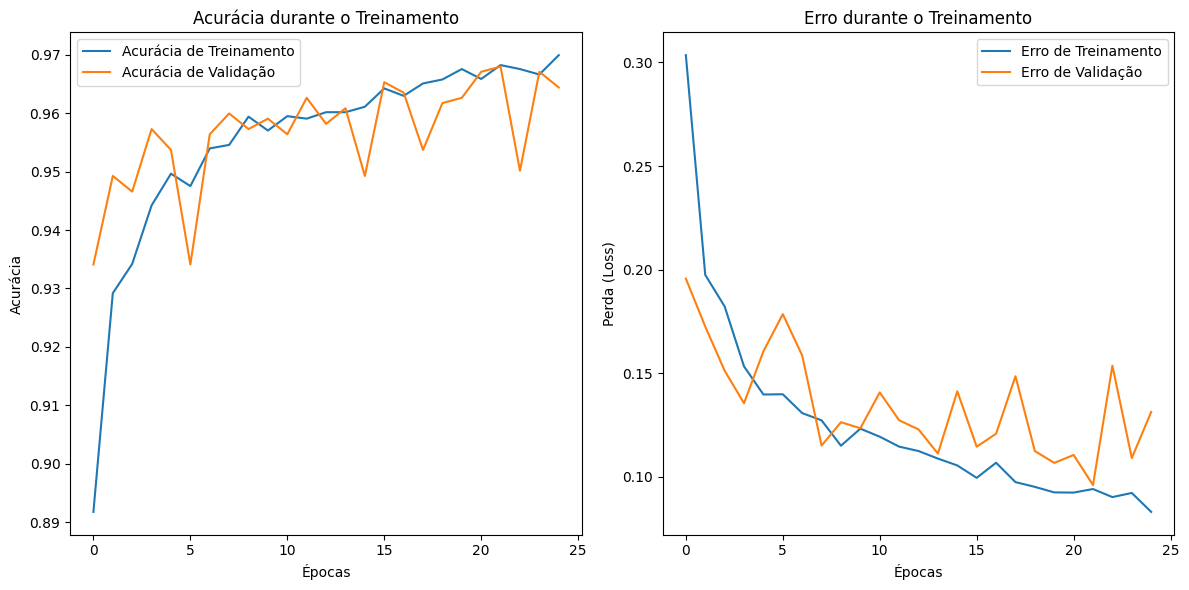

562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


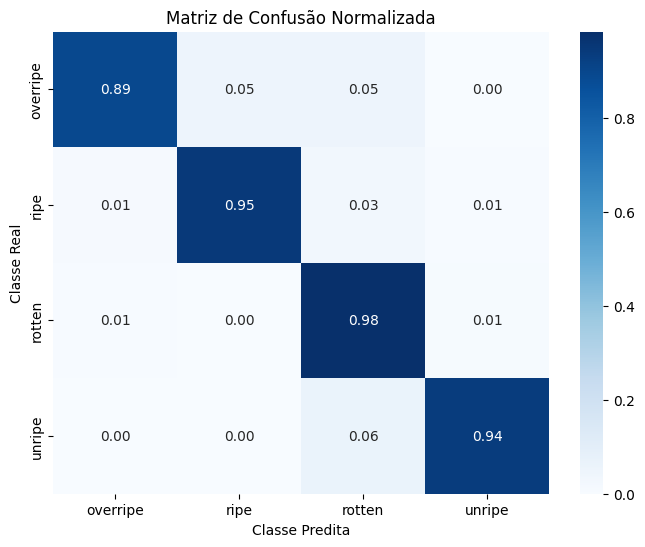

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
name="xception"
model = create_transfer_learning_model(base_model=base_model, x=x)
xception_train_generator, xception_val_generator, xception_test_generator = load_data(img_size=(150, 150))
history = train_model(model, xception_train_generator, xception_val_generator, epochs=25, name=name)
plot_training_history(history)
test_model(name, generator=densenet_test_generator)



51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 562 images belonging to 4 classes.
Found 11793 images belonging to 4 classes.
Found 1123 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8573 - loss: 0.4460
Epoch 1: val_loss improved from inf to 0.18733, saving model to /content/drive/MyDrive/banana-results/dense-net-169_best_weights.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 189s 401ms/step - accuracy: 0.8575 - loss: 0.4455 - val_accuracy: 0.9555 - val_loss: 0.1873
Epoch 2/25
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9472 - loss: 0.1567
Epoch 2: val_loss improved from 0.18733 to 0.15748, saving model to /content/drive/MyDrive/banana-results/dense-net-169_best_weights.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 97s 262ms/step - accuracy: 0.9472 - loss: 0.1567 - val_accuracy: 0.9564 - val_loss: 0.1575
Epoch 3/25
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9593 - loss: 0.1236
Epoch 3: val_loss improved from 0.15748 to 0.11198, saving model to /content/drive/MyDrive/banana-results/dense-net-169_best_weights.keras
369/369 ━━━━━━━━━━━━━━━━━━━━ 99s 267ms/step - accuracy: 0.9593 - loss: 0.1236 - va

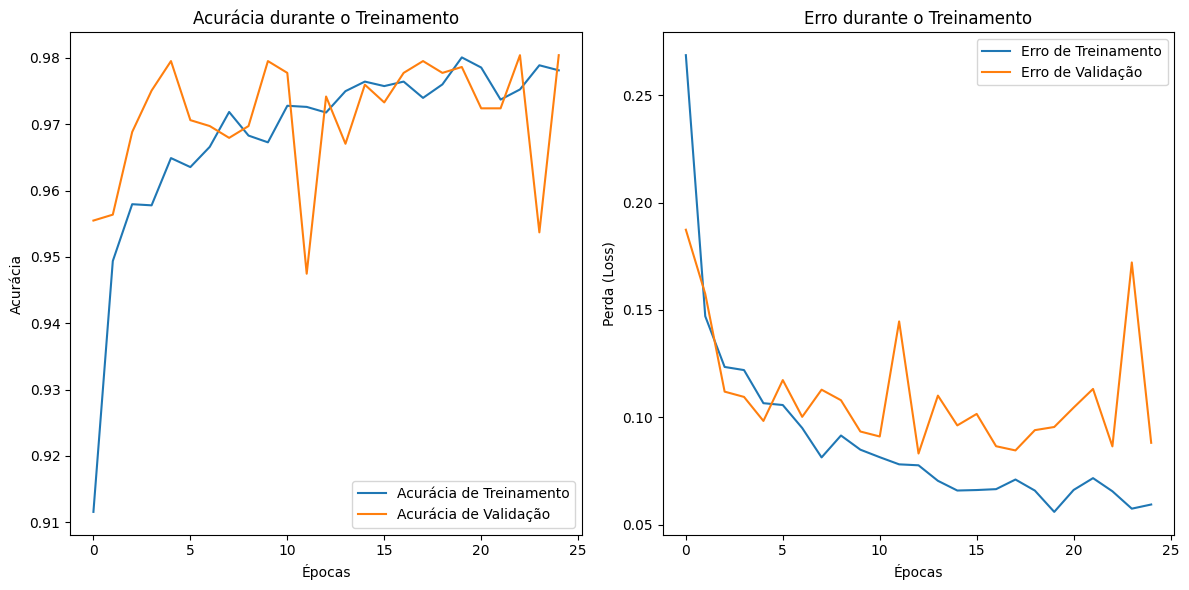

Carregando modelo: /content/drive/MyDrive/banana-results/dense-net-169_best_weights.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step


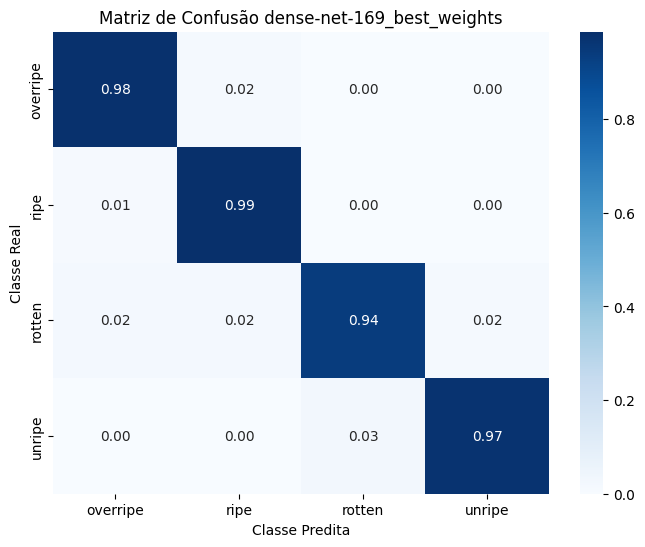

Carregando modelo: /content/drive/MyDrive/banana-results/dense-net-169_final_weights.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step


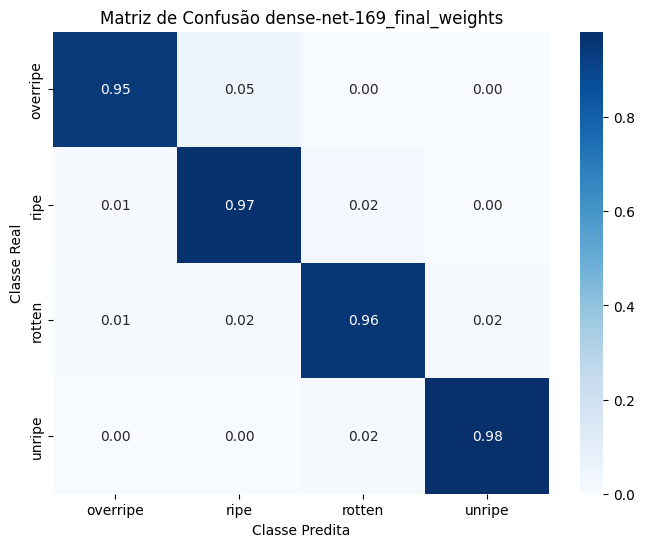

In [ ]:
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
name="dense-net-169"
model = create_transfer_learning_model(base_model=base_model, x=x)
densenet_train_generator, densenet_val_generator, densenet_test_generator = load_data(img_size=(150, 150))
history = train_model(model, densenet_train_generator, densenet_val_generator, epochs=25, name="dense-net-169")
plot_training_history(history)

test_model(name, generator=densenet_test_generator)
